In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.models as models
from torchvision.models import squeezenet1_0, SqueezeNet1_0_Weights
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report

In [2]:
train_path = '/kaggle/input/casting-512-512/Casting_512_512/train'
test_path = '/kaggle/input/casting-512-512/Casting_512_512/test'

In [3]:
transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
train_dataset = datasets.ImageFolder(root=train_path, transform=transformations)
test_dataset = datasets.ImageFolder(root=test_path, transform=transformations)

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [6]:
weights = SqueezeNet1_0_Weights.IMAGENET1K_V1
model = squeezenet1_0(weights=weights)

In [7]:
model.classifier[1] = nn.Conv2d(512, len(train_dataset.classes), kernel_size=(1,1))
model.num_classes = len(train_dataset.classes)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [10]:
train_loss_history = []
train_accuracy_history = []

num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100
    
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

Epoch 1/40, Train Loss: 0.8801, Train Accuracy: 57.46%
Epoch 2/40, Train Loss: 0.6784, Train Accuracy: 60.06%
Epoch 3/40, Train Loss: 0.6674, Train Accuracy: 59.29%
Epoch 4/40, Train Loss: 0.6494, Train Accuracy: 60.06%
Epoch 5/40, Train Loss: 0.6651, Train Accuracy: 60.54%
Epoch 6/40, Train Loss: 0.5922, Train Accuracy: 65.93%
Epoch 7/40, Train Loss: 0.6100, Train Accuracy: 60.44%
Epoch 8/40, Train Loss: 0.3951, Train Accuracy: 60.92%
Epoch 9/40, Train Loss: 1.6847, Train Accuracy: 64.00%
Epoch 10/40, Train Loss: 0.4449, Train Accuracy: 64.20%
Epoch 11/40, Train Loss: 0.3397, Train Accuracy: 62.08%
Epoch 12/40, Train Loss: 0.4112, Train Accuracy: 86.81%
Epoch 13/40, Train Loss: 0.3201, Train Accuracy: 90.76%
Epoch 14/40, Train Loss: 0.2266, Train Accuracy: 93.74%
Epoch 15/40, Train Loss: 0.2134, Train Accuracy: 93.36%
Epoch 16/40, Train Loss: 0.1769, Train Accuracy: 94.71%
Epoch 17/40, Train Loss: 0.3020, Train Accuracy: 92.30%
Epoch 18/40, Train Loss: 0.1657, Train Accuracy: 95.28%
E

In [12]:
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            
            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

        # Append the average validation loss for the epoch
        val_loss = val_running_loss / len(test_loader)
        val_loss_history.append(val_loss)

    val_accuracy = 100 * val_correct / val_total
    val_accuracy_history.append(val_accuracy)

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Validation Loss: 0.0983, Validation Accuracy: 97.70%


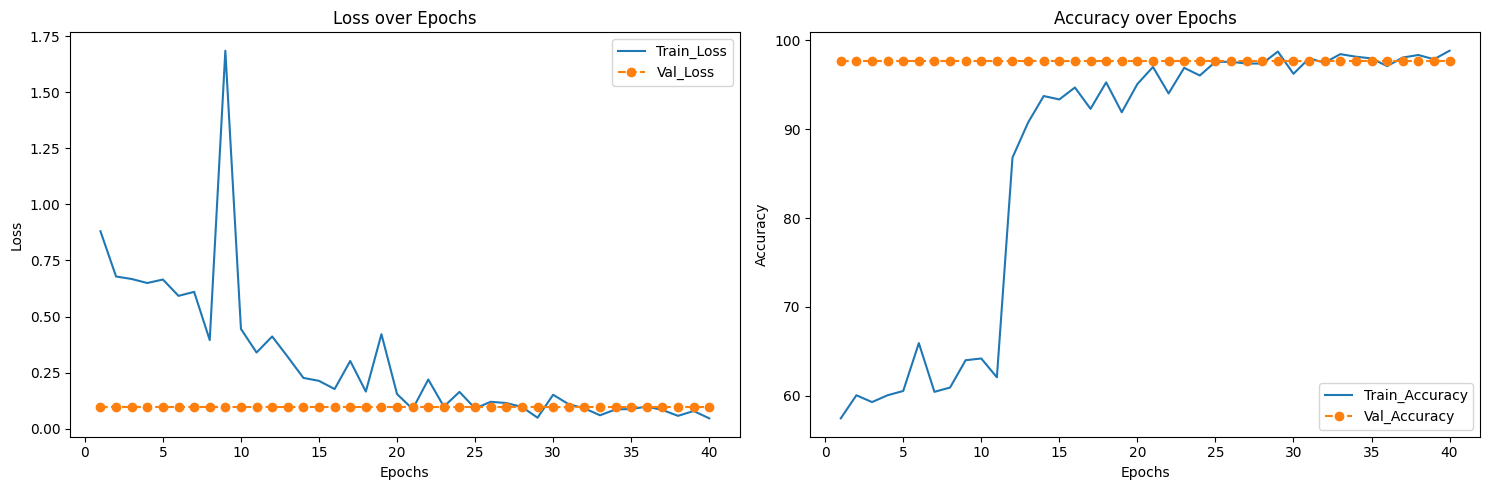

In [13]:
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train_Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Val_Loss', linestyle='--', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train_Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_history, label='Val_Accuracy', linestyle='--', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('Loss and Accuracy.png', dpi=300)
plt.show()

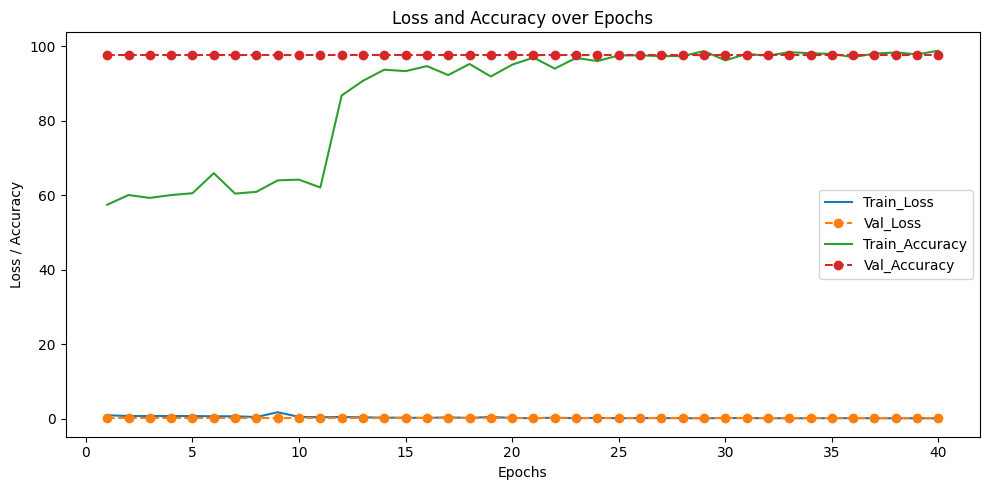

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Loss plot
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train_Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Val_Loss', linestyle='--', marker='o')

# Accuracy plot
plt.plot(range(1, num_epochs + 1), [acc for acc in train_accuracy_history], label='Train_Accuracy')
plt.plot(range(1, num_epochs + 1), [acc for acc in val_accuracy_history], label='Val_Accuracy', linestyle='--', marker='o')

plt.title('Loss and Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('Loss and AccuracySingle.png', dpi=300)
plt.show()

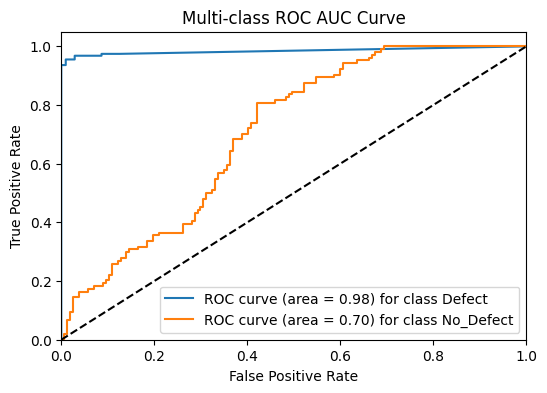

In [15]:
def plot_roc_curve(fpr, tpr, roc_auc, classes):
    plt.figure(figsize=(6, 4))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {classes[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.savefig('ROC_AUC.png', dpi=300)
    plt.show()

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(train_dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plot_roc_curve(fpr, tpr, roc_auc, train_dataset.classes)

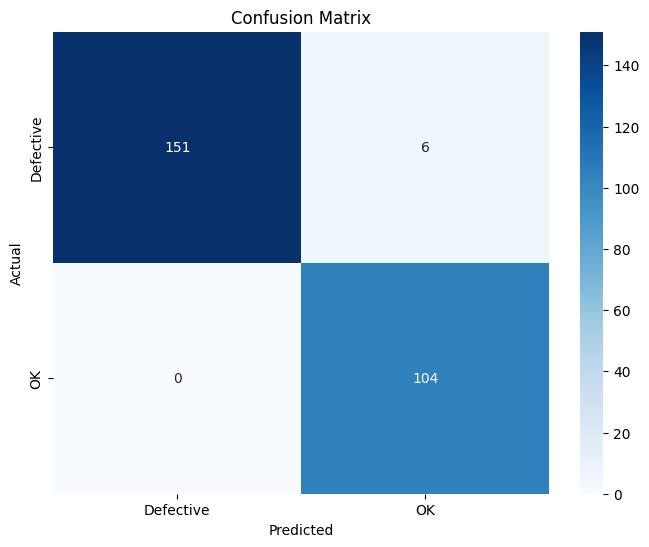

In [16]:
class_predictions = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, class_predictions)
labels = ['Defective', 'OK']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('ConfusionMatrix.png', dpi=300)
plt.show()

In [17]:
print(classification_report(y_true, class_predictions, target_names=train_dataset.classes))

              precision    recall  f1-score   support

      Defect       1.00      0.96      0.98       157
   No_Defect       0.95      1.00      0.97       104

    accuracy                           0.98       261
   macro avg       0.97      0.98      0.98       261
weighted avg       0.98      0.98      0.98       261



In [18]:
torch.save(model.state_dict(), 'SqueezeNet.pth')